In [17]:
#Regression Forecasting and Predicting
#Machine Learning with scikit-learn - Linear Regression
#project includes taking stock price data, performing simple feature transformations to get meaningful features, defining a label, and finally, running a linear regression
#Loading and Understanding Data
#Feature Engineering
#Creating Features and Label
#Scaling the features
#Regression
#Creating Training and Test Sets
#Using Linear Regression
#Before loading the data, I imported releavnt python modules as you can see in the first snippet of my code. For instance, to load our data-frame using quandl, I imported the module ‘quandl’. Once I had the data loaded, I tried understanding the data by printing the first few lines of the data frame using data.head() command.

import quandl, math
import numpy as np
import pandas as pd
from sklearn import preprocessing, cross_validation, svm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from matplotlib import style
import datetime
import time
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
plt.style.use('ggplot')

In [18]:
df = quandl.get('WIKI/MSFT')
#Declaring the data space-----
#This is the data we will use to train and test the model. 
#Note that the given date range is not going to work for all stock symbols. The user needs to be aware of the date a specific symbol started to trade otherwise the model will throw errors about missing data.

# Getting a peek into data 
# I am using round function to see only upto 2 decimal digits
print(df.head(2).round(1))
print('\n')

# Also print columns and index
print(df.columns)
print(df.index)

            Open  High   Low  Close     Volume  Ex-Dividend  Split Ratio  \
Date                                                                       
1986-03-13  25.5  29.2  25.5   28.0  3582600.0          0.0          1.0   
1986-03-14  28.0  29.5  28.0   29.0  1070000.0          0.0          1.0   

            Adj. Open  Adj. High  Adj. Low  Adj. Close   Adj. Volume  
Date                                                                  
1986-03-13        0.1        0.1       0.1         0.1  1.031789e+09  
1986-03-14        0.1        0.1       0.1         0.1  3.081600e+08  


Index([u'Open', u'High', u'Low', u'Close', u'Volume', u'Ex-Dividend',
       u'Split Ratio', u'Adj. Open', u'Adj. High', u'Adj. Low', u'Adj. Close',
       u'Adj. Volume'],
      dtype='object')
DatetimeIndex(['1986-03-13', '1986-03-14', '1986-03-17', '1986-03-18',
               '1986-03-19', '1986-03-20', '1986-03-21', '1986-03-24',
               '1986-03-25', '1986-03-26',
               ...
          

In [19]:
#Feature Engineering
#As you would notice the data has very strongly dependent features such as 'Open' and 'Adj. Open'. Let's deal with only adjusted data as they are largely self contained before we even get into feature engineering. We can also discard any other column that are irrelevant for or prediction.We can refine our features even further based on our general understanding of financial data. For instance, instead of dealing with High and Low separately, we could create volatility percentage as a new feature.
#Before getting into feature engineering, I noticed that the data had very similar features such as Open and Adj. Open. These features only differ if stock-split or merge happens. In this tutorial, I work with only adjusted quantities as they are largely self contained. I also discarded any other column that I thought weren’t that important (Ex-Dividend & Split Ratio).
#HL_PCT = {high - low}/{low*100}
#PCT_CHNG = {close - open}/{open*100}

#I refined features further based on general understanding of financial data (this step is optional if dealing with unfamiliar concepts). For instance, instead of dealing with High and Low separately, I created volatility percentages as my new features as shown below:
# Discarding features that aren't useful
df = df[['Adj. Open','Adj. High', 'Adj. Low', 'Adj. Close', 'Adj. Volume']]

# define a new feature, HL_PCT
df['HL_PCT'] = (df['Adj. High'] - df['Adj. Low'])/(df['Adj. Low']*100)

# define a new feature percentage change
df['PCT_CHNG'] = (df['Adj. Close'] - df['Adj. Open'])/(df['Adj. Open']*100)

df = df[['Adj. Close', 'HL_PCT', 'PCT_CHNG', 'Adj. Volume']]

print(df.head(1))

            Adj. Close    HL_PCT  PCT_CHNG   Adj. Volume
Date                                                    
1986-03-13     0.06472  0.001471   0.00098  1.031789e+09


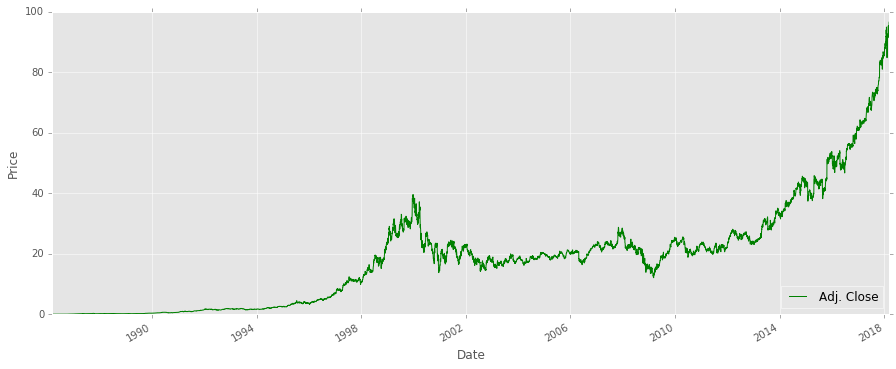

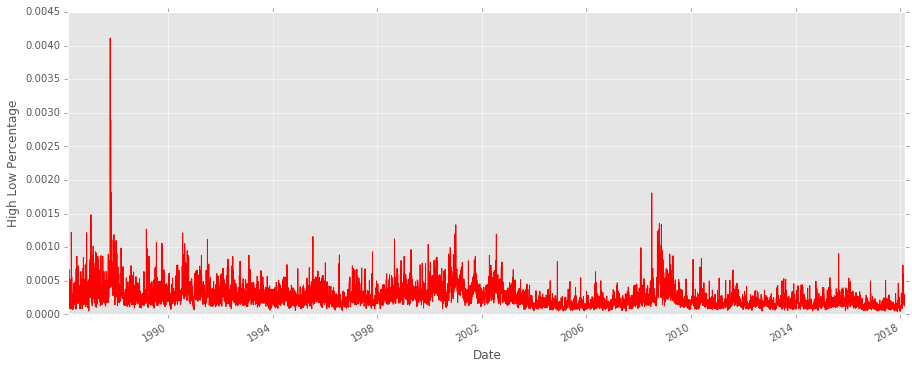

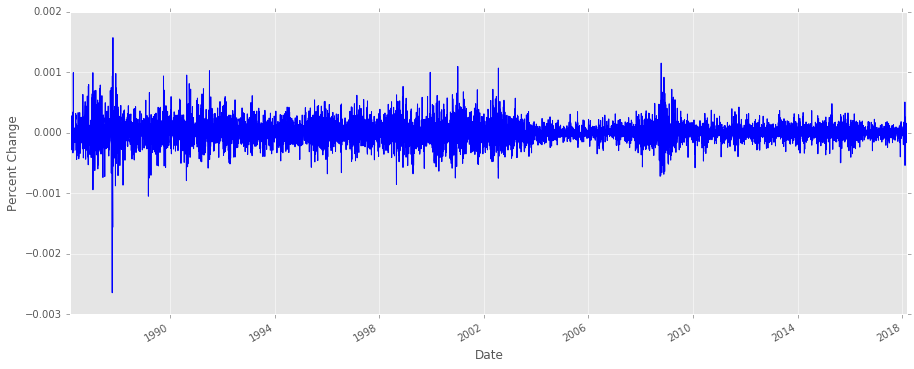

In [20]:
# Visualization
#I plotted my features as a function of dates, which are saved in the index of my data frame. Since the shares prices are almost linearly rising with time, linear regression should give me a reasonably good prediction!
df['Adj. Close'].plot(figsize=(15,6), color="green")
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

df['HL_PCT'].plot(figsize=(15,6), color="red")
plt.xlabel('Date')
plt.ylabel('High Low Percentage')
plt.show()

df['PCT_CHNG'].plot(figsize=(15,6), color="blue")
plt.xlabel('Date')
plt.ylabel('Percent Change')
plt.show()

In [21]:
#Machine Learning
#Creating Features and Label
#I chose the forecast of close, forecast_out after next 30 days for my label (the entity that I want to predict). This is competely flexible, the smaller the value of forecast_out, more accurate would be the model. 
#An important thing to note here is that once we have shifted our data according to number of days in forecast (say n) to create our column ‘label’, we will end up with Nan’s in last n rows of column ‘label’.
# pick a forecast column
forecast_col = 'Adj. Close'

# Chosing 30 days as number of forecast days
forecast_out = int(30)
print('length =',len(df), "and forecast_out =", forecast_out)

('length =', 8065, 'and forecast_out =', 30)


In [22]:
# Creating label by shifting 'Adj. Close' according to 'forecast_out'
df['label'] = df[forecast_col].shift(-forecast_out)
print(df.head(2))
print('\n')
# If we look at the tail, it consists of n(=forecast_out) rows with NAN in Label column 
print(df.tail(2))

            Adj. Close    HL_PCT  PCT_CHNG   Adj. Volume     label
Date                                                              
1986-03-13    0.064720  0.001471  0.000980  1.031789e+09  0.078011
1986-03-14    0.067031  0.000536  0.000357  3.081600e+08  0.078589


            Adj. Close    HL_PCT  PCT_CHNG  Adj. Volume  label
Date                                                          
2018-03-09       96.54  0.000162  0.000131   36145524.0    NaN
2018-03-12       96.77  0.000122  0.000028   25333720.0    NaN


In [23]:
# Define features Matrix X by excluding the label column which we just created 
X = np.array(df.drop(['label'], 1))

# Using a feature in sklearn, preposessing to scale features
X = preprocessing.scale(X)
print(X[1,:])

[-1.0591331   1.56923921  1.86532261  6.2877928 ]


In [24]:
# X contains last 'n= forecast_out' rows for which we don't have label data
# Put those rows in different Matrix X_forecast_out by X_forecast_out = X[end-forecast_out:end]

X_forecast_out = X[-forecast_out:]
X = X[:-forecast_out]
print ("Length of X_forecast_out:", len(X_forecast_out), "& Length of X :", len(X))

('Length of X_forecast_out:', 30, '& Length of X :', 8035)


In [25]:
# Similarly Define Label vector y for the data we have prediction for
# A good test is to make sure length of X and y are identical
y = np.array(df['label'])
y = y[:-forecast_out]
print('Length of y: ',len(y))

('Length of y: ', 8035)


In [26]:
#Regression
#Finally, I try out Linear Regression on our data set by dividing it into train and test data.
#Creating Training and Test Sets
#Using cross validation basically shuffles the data and according to our test_size criteria, splits the data into test and training data.

# Cross validation (split into test and train data)
# test_size = 0.2 ==> 20% data is test data
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = 0.2)

print('length of X_train and x_test: ', len(X_train), len(X_test))

('length of X_train and x_test: ', 6428, 1607)


In [27]:
# Train
#Training and testing
#Now it’s time to use linear regression. I first Split the data into 80% of training data and 20% of test data. I then, used Linear regression to train and test data. Finally, I tested the accuracy of my model on the test data.

clf = LinearRegression()
clf.fit(X_train,y_train)
# Test
accuracy = clf.score(X_test, y_test)
print("Accuracy of Linear Regression: ", accuracy)

('Accuracy of Linear Regression: ', 0.98662414887553662)


In [28]:
#Prediction
#It seems like this Linear Regression model did fairly well on the test data set! Now I can go ahead and use this model to predict prices of shares for the next 30 days.
# Predict using our Model
forecast_prediction = clf.predict(X_forecast_out)
print(forecast_prediction)

[ 96.06792815  94.83572523  97.08804597  96.36271173  93.85961735
  91.08115876  93.19975976  91.63277318  86.90333855  89.98543592
  91.11721536  91.84267226  92.78929593  94.71958847  94.08607899
  94.77984154  93.60130742  93.83311224  96.15791485  97.5454812
  96.37315675  95.91456634  94.95965499  95.1059147   95.73392536
  95.46838148  95.96624686  96.56670764  98.6713754   98.95532987]


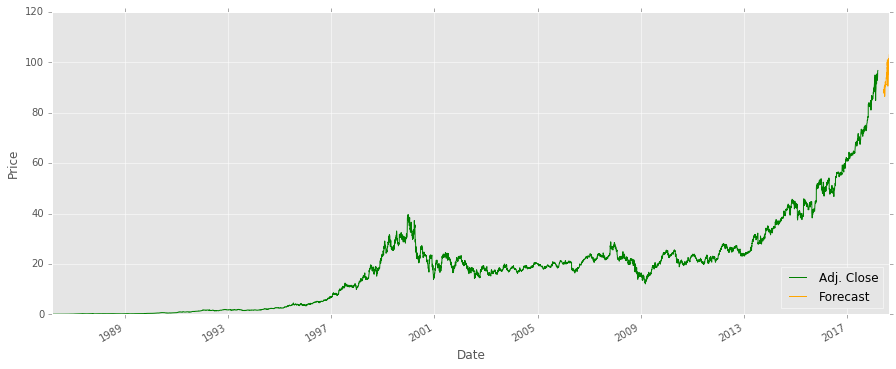

In [32]:
#I then plot the predicted prices as a function of dates. The piece of code below just adds dates for the predicted days.
# Plotting data
df['Forecast'] = np.nan

last_date = df.iloc[-1].name
last_unix = time.mktime(last_date.timetuple())
#last_unix = last_date.timestamp()
one_day = 86400
next_unix = last_unix + one_day

for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]

df['Adj. Close'].plot(figsize=(15,6), color="green")
df['Forecast'].plot(figsize=(15,6), color="orange")
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()



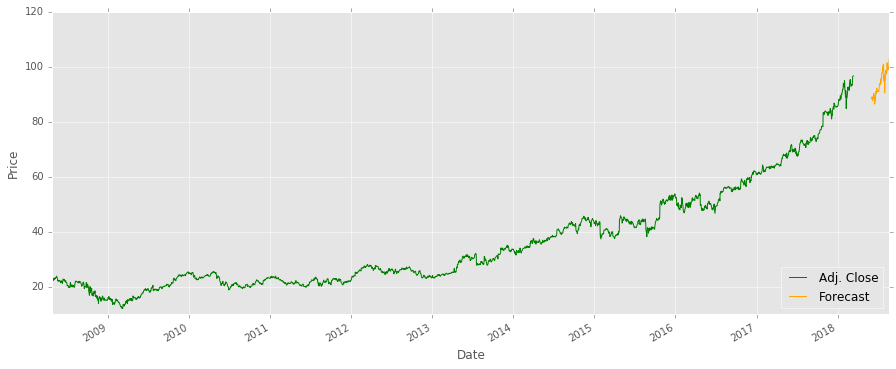

In [45]:
# Zoomed In to a year
df['Adj. Close'].plot(figsize=(15,6), color="green")
df['Forecast'].plot(figsize=(15,6), color="orange")
plt.xlim(xmin=datetime.date(2008, 4, 26))
plt.ylim(ymin=10)
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()
#There it is! The prediction of stock prices for the next 30 days, by using linear regression.

In [ ]:
#References-----
#https://www.youtube.com/channel/UCfzlCWGWYyIQ0aLC5w48gBQ
#https://www.quandl.com/
#http://suruchifialoke.com/2016-08-17-machine-learning-tutorial-with-python-I/
#https://pythonprogramming.net/forecasting-predicting-machine-learning-tutorial/
#https://machinelearningmastery.com/linear-regression-for-machine-learning/
#https://github.com/SuruchiFialoke/MachineLearning/blob/master/StockPrice/RegressionIntro.ipynb
